In [ ]:
#| default_exp asink

# The async version

## Setup

In [ ]:
#| export
import inspect, typing, mimetypes, base64, json
from collections import abc

from anthropic import AsyncAnthropic
from anthropic.types import ToolUseBlock
from toolslm.funccall import get_schema, mk_ns, call_func, call_func_async
from fastcore.meta import delegates
from fastcore.utils import *
from claudette.core import *
from msglm import mk_msg_anthropic as mk_msg, mk_msgs_anthropic as mk_msgs

In [ ]:
from cachy import enable_cachy

In [ ]:
enable_cachy()

In [ ]:
#| hide
from nbdev import show_doc

In [ ]:
from IPython.display import display,Image

## Async SDK

In [ ]:
model = models[1]
cli = AsyncAnthropic()

In [ ]:
prompt = "I'm Jeremy"
m = mk_msg(prompt)
r = await cli.messages.create(messages=[m], model=model, max_tokens=100)
r

Hi Jeremy! Nice to meet you. How can I help you today?

<details>

- id: `msg_01Q3123HGtAxWnUraLL65H24`
- container: `None`
- content: `[{'citations': None, 'text': 'Hi Jeremy! Nice to meet you. How can I help you today?', 'type': 'text'}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 10, 'output_tokens': 18, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
msgs = mk_msgs([prompt, r, "I forgot my name. Can you remind me please?"]) 
msgs

[{'role': 'user', 'content': "I'm Jeremy"},
 {'role': 'assistant',
  'content': [TextBlock(citations=None, text='Hi Jeremy! Nice to meet you. How can I help you today?', type='text')]},
 {'role': 'user', 'content': 'I forgot my name. Can you remind me please?'}]

In [ ]:
await cli.messages.create(messages=msgs, model=model, max_tokens=200)

Your name is Jeremy! You told me that at the start of our conversation. 😊

<details>

- id: `msg_01QTvdUwQAyKRQT3H73STdU3`
- container: `None`
- content: `[{'citations': None, 'text': 'Your name is Jeremy! You told me that at the start of our conversation. 😊', 'type': 'text'}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 42, 'output_tokens': 22, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
#| exports
class AsyncClient(Client):
    def __init__(self, model, cli=None, log=False, cache=False):
        "Async Anthropic messages client."
        super().__init__(model,cli,log,cache)
        if not cli: self.c = AsyncAnthropic(default_headers={'anthropic-beta': 'prompt-caching-2024-07-31'})

In [ ]:
c = AsyncClient(model)

In [ ]:
c._r(r)
c.use

In: 10; Out: 18; Cache create: 0; Cache read: 0; Total Tokens: 28; Search: 0; Fetch: 0

In [ ]:
#| exports
@asave_iter
async def _astream(o, cm, prefill, cb):
    async with cm as s:
        yield prefill
        async for x in s.text_stream: yield x
        o.value = await s.get_final_message()
        await cb(o.value)

In [ ]:
#| exports
@patch
@delegates(Client)
async def __call__(self:AsyncClient,
             msgs:list, # List of messages in the dialog
             sp='', # The system prompt
             temp=0, # Temperature
             maxtok=4096, # Maximum tokens
             maxthinktok=0, # Maximum thinking tokens
             prefill='', # Optional prefill to pass to Claude as start of its response
             stream:bool=False, # Stream response?
             stop=None, # Stop sequence
             tools:Optional[list]=None, # List of tools to make available to Claude
             tool_choice:Optional[dict]=None, # Optionally force use of some tool
             cb=None, # Callback to pass result to when complete
             **kwargs):
    "Make an async call to Claude."
    msgs,kwargs = self._precall(msgs, prefill, sp, temp, maxtok, maxthinktok, stream,
                                stop, tools, tool_choice, kwargs)
    m = self.c.messages
    f = m.stream if stream else m.create
    res = f(model=self.model, messages=msgs, **kwargs)
    async def _cb(v):
        self._log(v, prefill=prefill, msgs=msgs, **kwargs)
        if cb: await cb(v)
    if stream: return _astream(res, prefill, _cb)
    res = await res
    try: return res
    finally: await _cb(res)

In [ ]:
c = AsyncClient(model, log=True)
c.use

In: 0; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 0; Search: 0; Fetch: 0

In [ ]:
c.model = models[1]
await c('Hi')

Hi there! How are you doing? Is there something I can help you with today? 😊

<details>

- id: `msg_01NSbD7ZmQJKeY16gJ6apjAH`
- container: `None`
- content: `[{'citations': None, 'text': 'Hi there! How are you doing? Is there something I can help you with today? 😊', 'type': 'text'}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 8, 'output_tokens': 24, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
c.use

In: 8; Out: 24; Cache create: 0; Cache read: 0; Total Tokens: 32; Search: 0; Fetch: 0

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
sp = "You are a summing expert."

In [ ]:
tools=[sums]
choice = mk_tool_choice('sums')
choice

{'type': 'tool', 'name': 'sums'}

In [ ]:
msgs = mk_msgs(pr)
r = await c(msgs, sp=sp, tools=tools, tool_choice=choice)
r

[ToolUseBlock(id='toolu_016CNnqECCx2AcanFfQAR6Dz', caller=DirectCaller(type='direct'), input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')]

<details>

- id: `msg_013mLdHfZhRGsihW3NxusZWB`
- container: `None`
- content: `[{'id': 'toolu_016CNnqECCx2AcanFfQAR6Dz', 'caller': {'type': 'direct'}, 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 719, 'output_tokens': 57, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
#| export
async def mk_funcres_async(fc, ns):
    "Given tool use block `fc`, get tool result, and create a tool_result response."
    try: res = await call_func_async(fc.name, fc.input, ns=ns, raise_on_err=False)
    except KeyError: res = f"Error - tool not defined in the tool_schemas: {fc.name}"
    return dict(type="tool_result", tool_use_id=fc.id, content=str(res))

In [ ]:
#| export
async def mk_toolres_async(
    r:abc.Mapping, # Tool use request response from Claude
    ns:Optional[abc.Mapping]=None # Namespace to search for tools
    ):
    "Create a `tool_result` message from response `r`."
    cts = getattr(r, 'content', [])
    res = [mk_msg(r.model_dump(exclude_none=True), role='assistant')]
    if ns is None: ns=globals()
    tcs = [await mk_funcres_async(o, ns) for o in cts if isinstance(o,ToolUseBlock)]
    if tcs: res.append(mk_msg(tcs))
    return res

In [ ]:
tr = await mk_toolres_async(r, ns=globals())
tr

Finding the sum of 604542 and 6458932


[{'role': 'assistant',
  'content': [{'id': 'toolu_016CNnqECCx2AcanFfQAR6Dz',
    'caller': {'type': 'direct'},
    'input': {'a': 604542, 'b': 6458932},
    'name': 'sums',
    'type': 'tool_use'}]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_016CNnqECCx2AcanFfQAR6Dz',
    'content': '7063474'}]}]

In [ ]:
msgs += tr
r = contents(await c(msgs, sp=sp, tools=sums))
r

'The result of **604,542 + 6,458,932 = 7,063,474**!'

## Structured Output

In [ ]:
#| export
@patch
@delegates(Client.__call__)
async def structured(self:AsyncClient,
               msgs:list, # List of messages in the dialog
               tools:Optional[list]=None, # List of tools to make available to Claude
               ns:Optional[abc.Mapping]=None, # Namespace to search for tools
               **kwargs):
    "Return the value of all tool calls (generally used for structured outputs)"
    tools = listify(tools)
    if ns is None: ns=mk_ns(*tools)
    res = await self(msgs, tools=tools, tool_choice=tools,**kwargs)
    cts = getattr(res, 'content', [])
    tcs = [await call_func_async(o.name, o.input, ns=ns) for o in cts if isinstance(o,ToolUseBlock)]
    return tcs

In [ ]:
await c.structured(pr, sums)

Finding the sum of 604542 and 6458932


[7063474]

In [ ]:
c

[ToolUseBlock(id='toolu_01ENhz5EnfqZFT8PeizJ3gKr', caller=DirectCaller(type='direct'), input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')]

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 2,153 | 0.006459 |
| Output tokens | 166 | 0.002490 |
| Cache tokens | 0 | 0.000000 |
| Server tool use | 0 | 0.000000 |
| **Total** | **2,319** | **$0.008949** |

## AsyncChat

In [ ]:
#| exports
@delegates()
class AsyncChat(Chat):
    def __init__(self,
                 model:Optional[str]=None, # Model to use (leave empty if passing `cli`)
                 cli:Optional[Client]=None, # Client to use (leave empty if passing `model`)
                 **kwargs):
        "Anthropic async chat client."
        super().__init__(model, cli, **kwargs)
        if not cli: self.c = AsyncClient(model)

In [ ]:
sp = "Always use tools if available, and calculations are requested."
chat = AsyncChat(model, sp=sp)
chat.c.use, chat.h

(In: 0; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 0; Search: 0; Fetch: 0,
 [])

In [ ]:
#| exports
@patch
async def _append_pr(self:AsyncChat, pr=None):
    prev_role = nested_idx(self.h, -1, 'role') if self.h else 'assistant' # First message should be 'user' if no history
    if pr and prev_role == 'user': await self()
    self._post_pr(pr, prev_role)

In [ ]:
#| exports
@patch
async def __call__(self:AsyncChat,
                   pr=None,  # Prompt / message
                   temp=None, # Temperature
                   maxtok=4096, # Maximum tokens
                   maxthinktok=0, # Maximum thinking tokens
                   stream=False, # Stream response?
                   prefill='', # Optional prefill to pass to Claude as start of its response
                   tool_choice:Optional[Union[str,bool,dict]]=None, # Optionally force use of some tool
                   **kw):
    if temp is None: temp=self.temp
    await self._append_pr(pr)
    async def _cb(v):
        self.last = await mk_toolres_async(v, ns=limit_ns(self.ns, self.tools, tool_choice))
        self.h += self.last
    return await self.c(self.h, stream=stream, prefill=prefill, sp=self.sp, temp=temp, maxtok=maxtok, maxthinktok=maxthinktok, tools=self.tools, tool_choice=tool_choice, cb=_cb, **kw)

In [ ]:
await chat("I'm Jeremy")
await chat("What's my name?")

Your name is Jeremy! You told me at the start of our conversation. 😊

<details>

- id: `msg_01VyEoh1pWoHVEKzCh5SeRWP`
- container: `None`
- content: `[{'citations': None, 'text': 'Your name is Jeremy! You told me at the start of our conversation. 😊', 'type': 'text'}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 48, 'output_tokens': 21, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat = AsyncChat(model, sp=sp)
r = await chat("I'm Jeremy", stream=True)
async for o in r: print(o, end='')
r.value

Hi Jeremy! Nice to meet you. How can I help you today?

Hi Jeremy! Nice to meet you. How can I help you today?

<details>

- id: `msg_01JbxS96JDjpS6GtjdyjbHKa`
- container: `None`
- content: `[{'citations': None, 'text': 'Hi Jeremy! Nice to meet you. How can I help you today?', 'type': 'text', 'parsed_output': None}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 22, 'output_tokens': 18, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
pr = f"What is {a}+{b}?"
chat = AsyncChat(model, sp=sp, tools=[sums])
r = await chat(pr)
r

Finding the sum of 604542 and 6458932


I'll calculate the sum of 604542 and 6458932 right away!

<details>

- id: `msg_01AjLTTKCzEr2PgYoqcQrpPy`
- container: `None`
- content: `[{'citations': None, 'text': "I'll calculate the sum of 604542 and 6458932 right away!", 'type': 'text'}, {'id': 'toolu_01KhnEGLFGsYP9ePCfn6gf8b', 'caller': {'type': 'direct'}, 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 631, 'output_tokens': 92, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
await chat()

The sum of **604,542 + 6,458,932 = 7,063,474**!

<details>

- id: `msg_01MzE8hrFtWfJ8fT3PsZ8s9b`
- container: `None`
- content: `[{'citations': None, 'text': 'The sum of **604,542 + 6,458,932 = 7,063,474**!', 'type': 'text'}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 738, 'output_tokens': 28, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

AsyncChat handles missing tools gracefully. When a tool is called but not found in the namespace, it returns an error message rather than crashing.

In this test, we intentionally empty the namespace (`chat.ns={}`) to simulate what would happen if Claude hallucinated a tool or if a tool was missing. The `limit_ns` function (used in the `_cb` callback) would normally filter out hallucinated tools, but here we're testing the fallback behavior when tools aren't available.

In [ ]:
pr = f"What is {a}+{b}?"
chat = AsyncChat(model, sp=sp, tools=[sums])
chat.ns={}
r = await chat(pr)
r

I'll calculate the sum of 604542 and 6458932 right away!

<details>

- id: `msg_01AjLTTKCzEr2PgYoqcQrpPy`
- container: `None`
- content: `[{'citations': None, 'text': "I'll calculate the sum of 604542 and 6458932 right away!", 'type': 'text'}, {'id': 'toolu_01KhnEGLFGsYP9ePCfn6gf8b', 'caller': {'type': 'direct'}, 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 631, 'output_tokens': 92, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat.h

[{'role': 'user', 'content': 'What is 604542+6458932?'},
 {'role': 'assistant',
  'content': [{'text': "I'll calculate the sum of 604542 and 6458932 right away!",
    'type': 'text'},
   {'id': 'toolu_01KhnEGLFGsYP9ePCfn6gf8b',
    'caller': {'type': 'direct'},
    'input': {'a': 604542, 'b': 6458932},
    'name': 'sums',
    'type': 'tool_use'}]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_01KhnEGLFGsYP9ePCfn6gf8b',
    'content': 'Error - tool not defined in the tool_schemas: sums'}]}]

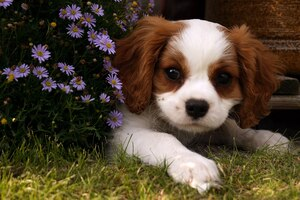

In [ ]:
fn = Path('samples/puppy.jpg')
img = fn.read_bytes()
Image(img)

In [ ]:
q = "In brief, what color flowers are in this image?"
msg = mk_msg([img, q])
await c([msg])

The flowers in the image are **purple/lavender** (blue-purple). They appear to be **asters**.

<details>

- id: `msg_01DUds87tAj47fozgFfbEPrQ`
- container: `None`
- content: `[{'citations': None, 'text': 'The flowers in the image are **purple/lavender** (blue-purple). They appear to be **asters**.', 'type': 'text'}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 110, 'output_tokens': 28, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Add `cache=True` to automatically add to Claude's KV cache.

In [ ]:
chat = AsyncChat(model, sp=sp, cache=True)
await chat("Lorem ipsum dolor sit amet" * 150)

It looks like you've sent a large block of repeated **"Lorem ipsum dolor sit amet"** placeholder text.

Could you clarify what you need? For example:

- ❓ Do you have a **question**?
- 📝 Do you need help with **writing or editing**?
- 🛠️ Was this sent **by mistake**?

I'm happy to help once I know what you're looking for! 😊

<details>

- id: `msg_01VhxH3pUWt1Z6ERyWFEpLvY`
- container: `None`
- content: `[{'citations': None, 'text': 'It looks like you\'ve sent a large block of repeated **"Lorem ipsum dolor sit amet"** placeholder text.\n\nCould you clarify what you need? For example:\n\n- ❓ Do you have a **question**?\n- 📝 Do you need help with **writing or editing**?\n- 🛠️ Was this sent **by mistake**?\n\nI\'m happy to help once I know what you\'re looking for! 😊', 'type': 'text'}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 1067, 'output_tokens': 103, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat.use

In: 1067; Out: 103; Cache create: 0; Cache read: 0; Total Tokens: 1170; Search: 0; Fetch: 0

In this followup call, nearly all the tokens are cached, so the only the new additional tokens are charged at the full rate.

In [ ]:
await chat("Whoops, sorry about that!")

No worries at all! 😄 It happens! 

So, what can I help you with today?

<details>

- id: `msg_013Z7HrwVhkDCPEhnj3yNHor`
- container: `None`
- content: `[{'citations': None, 'text': 'No worries at all! 😄 It happens! \n\nSo, what can I help you with today?', 'type': 'text'}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 1181, 'output_tokens': 28, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat.use

In: 2248; Out: 131; Cache create: 0; Cache read: 0; Total Tokens: 2379; Search: 0; Fetch: 0

## Extended Thinking

Let's call the model without extended thinking enabled. 

In [ ]:
chat = AsyncChat(model)
await chat("Write a sentence about Python!")

Here's a sentence about Python:

**Python is a versatile, beginner-friendly programming language known for its clean, readable syntax and wide range of applications, from web development and data science to artificial intelligence and automation.**

Would you like to know more about Python? 🐍

<details>

- id: `msg_0133ueaeXR2KvELPiPDnpFAC`
- container: `None`
- content: `[{'citations': None, 'text': "Here's a sentence about Python:\n\n**Python is a versatile, beginner-friendly programming language known for its clean, readable syntax and wide range of applications, from web development and data science to artificial intelligence and automation.**\n\nWould you like to know more about Python? 🐍", 'type': 'text'}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 13, 'output_tokens': 63, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Now, let's call the model with extended thinking enabled.

In [ ]:
r = await chat("Write a sentence about Python!", maxthinktok=1024)
r


Here's a sentence about Python:

**Python is one of the most popular programming languages in the world, loved by developers for its simplicity, powerful libraries, and ability to handle complex tasks with just a few lines of code.**

Fun fact: Python was named after the British comedy group **Monty Python**, not the snake! 🐍😄

Would you like to learn more about Python?

<details>
<summary>Thinking</summary>
The user wants another sentence about Python. Let me write a different one this time.
</details>


<details>

- id: `msg_01Vuqd8xUwuB2tTnmcexcfFp`
- container: `None`
- content: `[{'signature': 'Ev0BCkYICxgCKkAmUcWkc6z1j9s2pIRVL/EIaNbJYCaXR1stNeEAhQoCylzrssuUy2ZTq4vGWUl7WbH2AbV30H8aRazSNGwgnQp+Egzq7GmzjPUY/hkdH1oaDKbN8/A53z7nu/TenyIwIAhQomWRMzdCY7ueYlSChv7bcBIpnPT6Pf1gboh/KOlgAQIV0DRGX3r28/rVxj0KKmXdM/z1lMTxHXSMLE5PQkpDsNEavF0XqqGZlFXgd1Sg4mZSiaV3/9h9FTb2VWNtbpsvtztVbdvt4BbTnrO6YtNv5ehK0/7kaArbOwi61aQtZson8/+gmZgnox2vDieBHhpCc6t3ThgB', 'thinking': 'The user wants another sentence about Python. Let me write a different one this time.', 'type': 'thinking'}, {'citations': None, 'text': "Here's a sentence about Python:\n\n**Python is one of the most popular programming languages in the world, loved by developers for its simplicity, powerful libraries, and ability to handle complex tasks with just a few lines of code.**\n\nFun fact: Python was named after the British comedy group **Monty Python**, not the snake! 🐍😄\n\nWould you like to learn more about Python?", 'type': 'text'}]`
- model: `claude-sonnet-4-6`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': 'global', 'input_tokens': 114, 'output_tokens': 113, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
r.content

[ThinkingBlock(signature='Ev0BCkYICxgCKkAmUcWkc6z1j9s2pIRVL/EIaNbJYCaXR1stNeEAhQoCylzrssuUy2ZTq4vGWUl7WbH2AbV30H8aRazSNGwgnQp+Egzq7GmzjPUY/hkdH1oaDKbN8/A53z7nu/TenyIwIAhQomWRMzdCY7ueYlSChv7bcBIpnPT6Pf1gboh/KOlgAQIV0DRGX3r28/rVxj0KKmXdM/z1lMTxHXSMLE5PQkpDsNEavF0XqqGZlFXgd1Sg4mZSiaV3/9h9FTb2VWNtbpsvtztVbdvt4BbTnrO6YtNv5ehK0/7kaArbOwi61aQtZson8/+gmZgnox2vDieBHhpCc6t3ThgB', thinking='The user wants another sentence about Python. Let me write a different one this time.', type='thinking'),
 TextBlock(citations=None, text="Here's a sentence about Python:\n\n**Python is one of the most popular programming languages in the world, loved by developers for its simplicity, powerful libraries, and ability to handle complex tasks with just a few lines of code.**\n\nFun fact: Python was named after the British comedy group **Monty Python**, not the snake! 🐍😄\n\nWould you like to learn more about Python?", type='text')]

## Export -

In [ ]:
#| hide
#| eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()